# **AiiDA-KKR tutorial - using workflows part II**

In this tutorial, we perform an impurity embedding calculation based on the converged calculation of bcc Fe from the [AiiDA-KKR workflows tutorial I](AiiDA-KKR_tutorial_workflows_I.ipynb).

In this section, you will learn about
* the impurity embedding workflow
* how to reuse data for multiple impurity calculations
* the impurity DOS workflow

We start with importing the SCF workflow for bcc Fe into which an impurity should be placed.

> **Note:**\
> In this tutorial the submission statements are commented out and instead the finished calculations are imported using the `load_node()` function.
> This requires importing the tutorial dataset using `verdi import aiida-kkr_tutorial_workflows_II.aiida` in the terminal before executing this workflow.

In [1]:
#load aiida environment and connect to database
from aiida import load_profile
profile = load_profile()

# load classes and functions
from aiida.orm import CifData, Code, Dict, load_node
from aiida.engine import submit
from aiida_kkr.tools import kkrparams, plot_kkr

# load the scf workflow for bulk Fe using the conventional structure and extract the remote_folder of the converged calculation
scf_conv = load_node('06e3d90e-b5f4-4b9a-b187-bb2e1a05d674')
converged_host_remote = scf_conv.outputs.last_RemoteData

## **1. `kkr_imp_wc` - full KKR impurity embedding**

The goal is to embed a substitutional Cr defect into bulk Fe. For this, we will use the top-level `kkr_imp_wc` workflow of AiiDA-KKR that deal first writes out the host's Green function for the impurity cluster, creates the impurity starting potential, and finally converges the impurity by running a series of `KkrimpCalculation`s. The workflow has the following input and output nodes:

**Inputs:**
* `structure` - crystal structure for which the calculation is done (`StructureData`, *optional*)
* `remote_data` - parent calculation folder, used to continue a calculation instead of starting from a `StructureData` node (`RemoteData`, *optional*, required if structure is not in inputs)
* `wf_parameters` - settings for the workflow (Dict, *optional*)
* `options` - computer options (e.g. `'resources'={...}`, `'queue_name=...'`) that control how a calculation runs on the cluster (Dict, *optional*)
* `calc_parameters` - KKR parameters like the LMAX cutoff (`Dict`, *optional*)
* `voronoi` - Voronoi code installation (`Code`, *required* if structure is in inputs)
* `kkr` - KKR code installation (`Code`, *required*)
* `kkrimp` - KKR code installation (`Code`, *required*)

**Outputs:**
* `last_calc_output_parameters` - link to the last calculation's parsed output parameters (`Dict` node)
* `remote_data_gf` - link to the last calculation's `remote_folder` (`RemoteData` node)
* `last_calc_info` - information on the last caluclation (uuid's etc., `Dict` node)
* `workflow_info` - collected information of the workflow (`Dict` node)
* `converged_potential` - converged impurity potential (`SingleFileData` node)

>**Note:**\
> The `KkrimpCalculation` can also start with an impurity potential (`SingleFileData` node). This will be used later to continue with the impurity DOS calculation from the converged impurity potential.

We will first construct the `imp_info` Dict input node that defines the impurity setup. In this example, we start from the converged SCF calculation of bcc Fe in the conventional unit cell which has two (equivalent) atoms.

In [2]:
scf_conv.inputs.structure.sites

[<Site: kind name 'Fe' @ 0.0,0.0,0.0>,
 <Site: kind name 'Fe' @ 1.42002584,1.42002584,1.42002584>]

In this example, we are going to substitute the second site with a Cr impurity (`Zimp=24`) and want to include all host atoms within a radius of 4 Ang. for the charge screening. This can be done by choosing `ilayer_center=1` (remember that python starts counting at 0) and `Rcut=4.`:

In [3]:
imp_info = Dict(dict=dict(Zimp=24., ilayer_center=1, Rcut=4.))

We again use the `get_wf_defaults` method to get starting values for the different input nodes of the `kkr_imp_wc` workflow and we change some of the default parameters for this tutorial:

In [4]:
from aiida_kkr.workflows import kkr_imp_wc
options, settings_imp, settings_vorostart = kkr_imp_wc.get_wf_defaults()

# settings for kkrimp-scf sub workflow
# reduce convegence criterion, increase mixing steps)
settings_imp['convergence_criterion'] = 1e-6
settings_imp['nsteps'] = 100
settings_imp['strmix'] = 0.01
settings_imp['aggrmix'] = 0.03
settings_imp['threshold_aggressive_mixing'] = 0.05

# settings for vorostart sub-workflow
settings_vorostart['natom_in_cls_min'] = 25

# use the options for the oscar partition of iffslurm (defined in "basic Calculations" part of the AiiDA-KKR tutorial)
options_slurm_oscar = load_node('68da1dbd-775e-4594-9c29-3e21815173bb')

Version of workflow: 0.8.0


Now we are ready to submit the process:

In [5]:
# create process builder
builder = kkr_imp_wc.get_builder()

# definition of the impurity
builder.impurity_info = imp_info
# converged host calculation's remote folder
builder.remote_data_host = converged_host_remote
# settings for the impurity scf
builder.wf_parameters = Dict(dict=settings_imp)
# settings for impurity start potential generation
builder.voro_aux_parameters = Dict(dict=settings_vorostart)

# set the codes and options
builder.voronoi = Code.get_from_string('voronoi_intel@iffslurm')
builder.kkr = Code.get_from_string('kkrhost_develop_intel@iffslurm')
builder.kkrimp = Code.get_from_string('kkrimp_intel@iffslurm')
builder.options = options_slurm_oscar

# set a calculation label and a description (optional)
builder.metadata.label = 'Cr:Fe'
builder.metadata.description = 'impurity in bcc Fe'

# finally submit the workflow and wait
#imp_scf = submit(builder)
imp_scf = load_node('ca47ad39-c4eb-4a81-bde0-97216d40931e')

The `plot_kkr` tool again gives us an overview plot of the workflow:

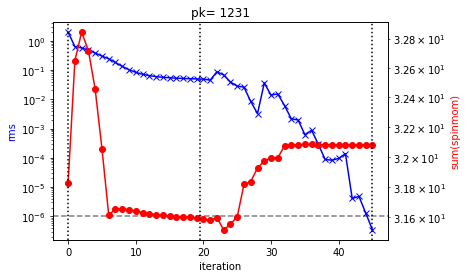

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 66.92941982063323), p…

In [6]:
plot_kkr(imp_scf, silent=True)

In [7]:
# use this command to check on the status of the workflow:
#!verdi process status <id-of-the-workflow>

## **2. reuse Green function for a second impurity**

We can easily do a second impurity calculation. Here we want to place Mn instead of Cr into bcc Fe and reuse the previous settings. Since the impurity cluster is the same we can even reuse the already written out Green function of the host. We find this in the output of the previous impurity SCF workflow. To skip the GF write-out step in this calculation we remove the `remote_data_host` input from the builder and instead add the `remote_data_gf` input. We can then submit this calculation which will finish faster since the GF write-out step is skipped (you can see this by comparing the `verdi process status <id>` outputs of the provenance graphs of the two calculations.

In [8]:
builder = imp_scf.get_builder_restart()

imp_info = builder.impurity_info.get_dict()
imp_info['Zimp'] = 25.0
builder.impurity_info= Dict(dict=imp_info)

builder.metadata.label = 'Mn:Fe'

# remote remote_data_host input and add remote_data_gf input
# this will trigger reusing the already existing gf
builder.pop('remote_data_host')
builder.remote_data_gf = imp_scf.outputs.remote_data_gf

#imp_scf_Mn = submit(builder)
imp_scf_Mn = load_node('f43cff25-d87a-47fd-a7ad-70103dd94010')

In [9]:
#!verdi process status 992

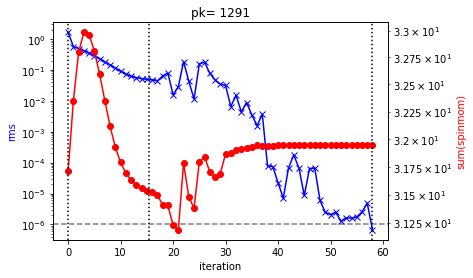

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 66.92941982063323), p…

In [10]:
plot_kkr(imp_scf_Mn, silent=True)

From the output, we can compare some of the output properties of the calculation. Here we look at the magnetic moments in the different shells around the impurities:

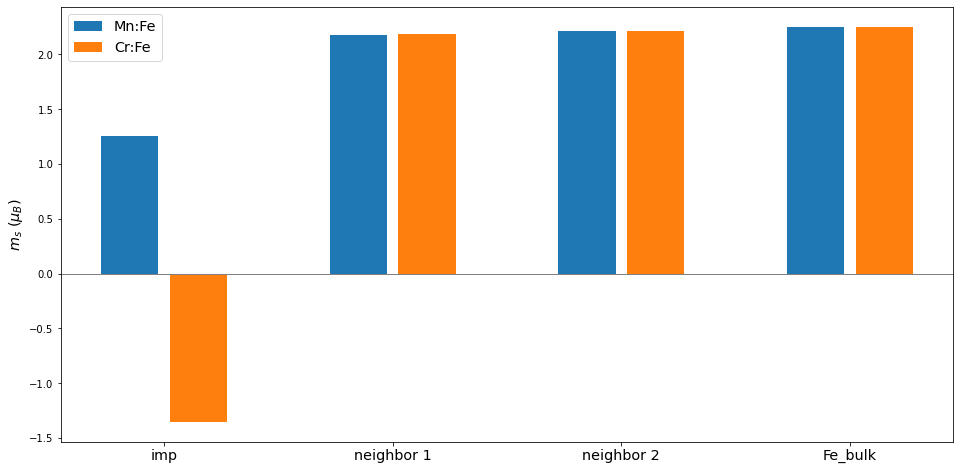

In [11]:
import numpy as np

import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))

for i, imp in enumerate([imp_scf_Mn, imp_scf]):
    moms = np.round(np.array(imp.outputs.last_calc_output_parameters['convergence_group']['total_spin_moment_all_iterations'][0])[:,-1], 3)
    # extract moments of the different shells
    ms_imp = moms[0]
    ms_shell1 = moms[1]
    ms_shell2 = moms[9]
    # reference bulkf Fe value
    ms_Fe_bulk = scf_conv.outputs.last_calc_out['magnetism_group']['spin_moment_per_atom'][0]

    moms = [ms_imp, ms_shell1, ms_shell2, ms_Fe_bulk]
    names = [imp.label, 'neighbor 1', 'neighbor 2', 'Fe_bulk']

    x = np.arange(len(moms))
    plt.bar(2*x-0.3+i*0.6, moms, label=names[0], width=0.5)
    plt.xticks(2*x, ['imp']+names[1:], fontsize='x-large')
    plt.legend(fontsize='x-large')
    plt.ylabel('$m_s$ ($\mu_B$)', fontsize='x-large')
    plt.axhline(0, color='grey', lw=1)

## **3. impurity DOS**

Once we have converged the impurities we can also compute their DOS. In this example, we will additionally set the `retrieve_kkrflex` flag in the `wf_parameters` input to `False`. This can be used to suppress retrieval of the host's Green function (i.e. the *kkrflex_\** files). We do this because we expect that we will not need to store these files permanently in the AiiDa repository. Thus we minimize the size of the file repository.

We again first set up the settings for the workflow:

In [12]:
from aiida_kkr.workflows import kkr_imp_dos_wc
settings = kkr_imp_dos_wc.get_wf_defaults()

# save space in the database and do not retrieve the KKRflex files and calculate the l and m resolved DOS instead of the l-resolved one
settings['retrieve_kkrflex'] = False
settings['lmdos'] = True

# change energy range to zoom around Fermi level
settings['dos_params']['emin'] = -5
settings['dos_params']['emax'] = 2

Version of workflow: 0.6.9


In this example, we will also use a `Group` to save out workflow nodes. Groups are a useful tool to organize your data.

In [13]:
def get_or_create_group(groupname):
    """
    load a group by label 'groupname'
    if the group does not exist create it
    """
    from aiida.orm import Group, load_group
    from aiida.common import NotExistent
    
    try:
        imp_dos_group = load_group(groupname)
    except NotExistent:
        imp_dos_group = Group(label='imp_dos_nodes')
        imp_dos_group.store()
    
    return imp_dos_group


imp_dos_group = get_or_create_group('imp_dos_nodes')

We are now submitting the DOS calculations for the two workflows directly in a loop and add the workflow nodes to the Group.

In [14]:
for imp in [imp_scf, imp_scf_Mn]:
    builder = kkr_imp_dos_wc.get_builder()

    # reuse code settingf from scf calculation
    # attention: for retrieve_kkrflex=False in the settings we need to use the same computer for the GF writeout and the impurity calculation
    builder.kkr = imp_scf.inputs.kkr
    builder.kkrimp = imp_scf.inputs.kkrimp
    builder.options = imp_scf.inputs.options

    builder.host_remote = imp_scf.inputs.remote_data_host
    
    builder.imp_pot_sfd = imp.outputs.converged_potential

    builder.wf_parameters = Dict(dict=settings)

    plabel = imp.label+'_DOS'
    builder.metadata.label = plabel

    #submit only if a calculation with the same name does not exist in the group already
    if plabel not in [n.label for n in imp_dos_group.nodes]:
        imp_dos = submit(builder)
        imp_dos_group.add_nodes(imp_dos)
        print('submitted DOS for', imp.label)

# show the labels and process states of the processes
[(n.label, n.process_state) for n in imp_dos_group.nodes]

[('Cr:Fe_DOS', <ProcessState.FINISHED: 'finished'>),
 ('Mn:Fe_DOS', <ProcessState.FINISHED: 'finished'>)]

Finally, we can compare the DOS of the impurities. Here we use the keyword arguments to add the plots into the same figure.

No handles with labels found to put in legend.


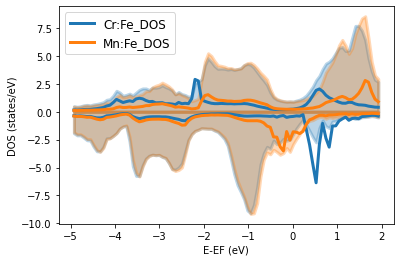

In [15]:
plt.figure()
for i, imp_dos in enumerate(imp_dos_group.nodes):
    # plot the contribution of the total impurity cluster into the background
    # we scale this down by 0.5 to have copatible y-scales
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=None,
             noshow=True, nofig=True, color='C'+str(i),
             filled=True, alpha=0.3, yscale=0.5, lw=3
            )
    # highlight the contibution of the impurity (iatom=0)
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
             noshow=True, nofig=True, color='C'+str(i),
             lw=3, iatom=0, 
            )
plt.legend(loc=2, fontsize='large')
plt.title('')
plt.show()